In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.stats import sem
import scipy.stats as stats

In [ ]:
part_names_all = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10',
                 'P11','P12']
sl_start = [88500,95000,1,109650,114150,119250,3897700,3910550,3915450,3974610,3979310,3984910]
sl_end = [91200,98000,1000000,115000,118000,125000,100000000,100000000,100000000,100000000,100000000,100000000]
nSubj = len(part_names_all)
nSubj = len(part_names_all)
durs = [200,300,400,500,600,700,800]

dat_path = os.getcwd()+"/data_time/"
all_hits = np.zeros((nSubj,4))
RTs = np.full((nSubj,2,84),np.nan)
all_time_resp=np.zeros((nSubj,2,7,3))
half_time_resp=np.zeros((nSubj,2,7,3))
full_time_resp=np.zeros((nSubj,2,7,3))

for iSub,idSub in enumerate(part_names_all):
    path = dat_path+idSub
    flist = sorted(os.listdir(path))
    cue_count = 0
    rob_count = 0
    user_count = 0
    stop_count = 0
    resp_count = 0
    for i in range(len(flist)):
        
        if ("cue_state" in flist[i]) | ("Cue_state" in flist[i]):
            if cue_count == 0:
                cue_df = pd.read_csv(path+"/"+flist[i])
                cue_df.columns = ["timestamp","channel_0"]
                cue_count += 1
            elif cue_count == 1:
                tmp = pd.read_csv(path+"/"+flist[i])
                tmp.columns = ["timestamp","channel_0"]
                cue_df = pd.concat([cue_df,tmp],ignore_index=True)
            
            

            print(flist[i])
        elif ("rob_state" in flist[i]) | ("Robot_state" in flist[i]):
            if rob_count == 0:
                robst_df = pd.read_csv(path+"/"+flist[i])
                robst_df.columns = ["timestamp","channel_0"]
                rob_count +=1
            elif rob_count == 1:
                tmp = pd.read_csv(path+"/"+flist[i])
                tmp.columns = ["timestamp","channel_0"]
                robst_df = pd.concat([robst_df,tmp],ignore_index=True)

        
    

            print(flist[i])
        elif ("user_input" in flist[i]) | ("User_input" in flist[i]):
            if user_count == 0:
                resp_df = pd.read_csv(path+"/"+flist[i])
                resp_df.columns = ["timestamp","channel_0"]
                user_count+=1
            elif user_count ==1 :
                tmp = pd.read_csv(path+"/"+flist[i])
                tmp.columns = ["timestamp","channel_0"]
                resp_df = pd.concat([resp_df,tmp],ignore_index=True)
        elif "Stop_state" in flist[i]:
            if stop_count == 0:
                stop_df = pd.read_csv(path+"/"+flist[i])
                stop_df.columns = ["timestamp","channel_0"]
                stop_count+=1
            elif stop_count ==1 :
                tmp = pd.read_csv(path+"/"+flist[i])
                tmp.columns = ["timestamp","channel_0"]
                stop_df = pd.concat([stop_df,tmp],ignore_index=True)

    cue_df = cue_df[(cue_df.timestamp>(sl_start[iSub]-1)) & (cue_df.timestamp<(sl_end[iSub]+1))].reset_index()
    robst_df = robst_df[(robst_df.timestamp>(sl_start[iSub]-1)) & (robst_df.timestamp<(sl_end[iSub]+1))].reset_index()
    resp_df = resp_df[(resp_df.timestamp>(sl_start[iSub]-1)) & (resp_df.timestamp<(sl_end[iSub]+1))].reset_index()
    stop_df = stop_df[(stop_df.timestamp>(sl_start[iSub]-1)) & (stop_df.timestamp<(sl_end[iSub]+1))].reset_index()
    cue_1_idx = find_peaks(cue_df.channel_0,[1,1],distance=100)
    cue_3_idx = find_peaks(cue_df.channel_0,[3,3],distance=100)
    print(len(cue_3_idx[0]))
    print(len(cue_1_idx[0]))
    resp_idx = find_peaks(resp_df.channel_0,[1,1],distance=100)
    print(len(resp_idx[0]))

    resp_count=0
    for iCue in range(len(cue_1_idx[0])):
        cue_ts = cue_df.timestamp[cue_1_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+5))].reset_index()
        stop_win = stop_df[(stop_df.timestamp>(cue_ts-1))& (stop_df.timestamp<(cue_ts+5))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_tses = rob_win.timestamp[rob_win.channel_0!=0].values
        stop_state = max(stop_win.channel_0)
        stop_state = int(stop_state)
        #print(stop_state)
        rob_ts = rob_tses[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts-1))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        time_resp = max(resp_win.channel_0)


        rt=0
        #print(len(resp_idx))
        if time_resp>0:
            if rob_state ==1:
                if len(resp_idx)>0:
                    resp_ts = resp_win.timestamp[resp_idx[0]]
                    #hits[0] = hits[0]+1
                    rt = resp_ts-rob_ts
                    RTs[iSub,0,iCue] = rt
                if time_resp == 4:
                    
                    all_time_resp[iSub,0,stop_state-1,1] +=1 
                    if resp_count <42:
                        half_time_resp[iSub,0,stop_state-1,1] +=1
                    else:
                        full_time_resp[iSub,0,stop_state-1,1] +=1
                all_time_resp[iSub,0,stop_state-1,2] +=1 
                all_time_resp[iSub,0,stop_state-1,0] =durs[stop_state-1]
                if resp_count <42:
                    half_time_resp[iSub,0,stop_state-1,2] +=1 
                    half_time_resp[iSub,0,stop_state-1,0] =durs[stop_state-1]  
                else:
                    full_time_resp[iSub,0,stop_state-1,2] +=1 
                    full_time_resp[iSub,0,stop_state-1,0] =durs[stop_state-1]  
                #print("No CUE: ",rt)
                resp_count+=1
    resp_count=0
    for iCue in range(len(cue_3_idx[0])):
        cue_ts = cue_df.timestamp[cue_3_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+5))].reset_index()
        stop_win = stop_df[(stop_df.timestamp>(cue_ts-1))& (stop_df.timestamp<(cue_ts+5))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_tses = rob_win.timestamp[rob_win.channel_0!=0].values
        stop_state = max(stop_win.channel_0)
        stop_state = int(stop_state)
        #print(stop_state)
        rob_ts = rob_tses[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts-1))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        time_resp = max(resp_win.channel_0)
        '''
        plt.figure()
        plt.plot(resp_win.channel_0)
        plt.show()
        plt.figure()
        plt.plot(stop_win.channel_0,color='red')
        plt.show()
        '''
        rt=0
        #print(len(resp_idx))
        if time_resp>0:
            
            if rob_state ==1:
                resp_count=resp_count+1
                
                if len(resp_idx)>0:
                    resp_ts = resp_win.timestamp[resp_idx[0]]
                    #hits[0] = hits[0]+1
                    rt = resp_ts-rob_ts
                    RTs[iSub,1,iCue] = rt
                if time_resp == 4:
                    
                    all_time_resp[iSub,1,stop_state-1,1] +=1 
                    if resp_count <42:
                        half_time_resp[iSub,1,stop_state-1,1] +=1
                    else:
                        full_time_resp[iSub,1,stop_state-1,1] +=1
                all_time_resp[iSub,1,stop_state-1,2] +=1 
                all_time_resp[iSub,1,stop_state-1,0] =durs[stop_state-1]
                if resp_count <42:
                    half_time_resp[iSub,1,stop_state-1,2] +=1 
                    half_time_resp[iSub,1,stop_state-1,0] =durs[stop_state-1]  
                else:
                    full_time_resp[iSub,1,stop_state-1,2] +=1 
                    full_time_resp[iSub,1,stop_state-1,0] =durs[stop_state-1]  
                
                #print("Hap CUE: ",rt)  


Text(0, 0.5, 'Reaction Time [s]')

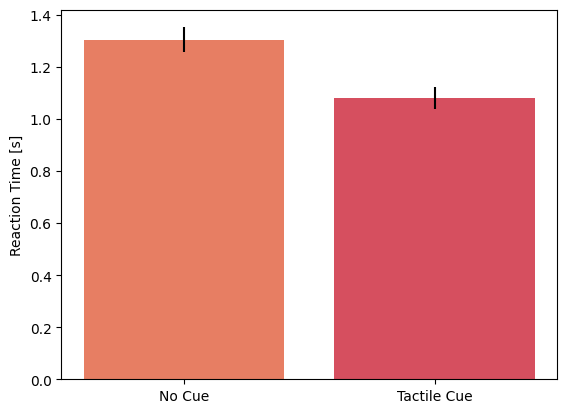

In [8]:
import seaborn as sns
outlier =8

all_mean_RTs= mean_RTs
all_mean_RTs=np.delete(all_mean_RTs,outlier,axis=0)

means = [np.nanmean(all_mean_RTs[:,0]),np.nanmean(all_mean_RTs[:,1])]
sems = [sem(all_mean_RTs,axis=0)]
stds = [np.std(all_mean_RTs,axis=0)]

plt.bar([0,1],means,color = sns.color_palette("flare",4))
plt.errorbar([0,1],means,yerr=sems,fmt='None',color='k')
plt.xticks([0,1],labels=['No Cue','Tactile Cue'])
plt.ylabel('Reaction Time [s]')

In [13]:
full_time_resp_wocue = full_time_resp[:,0,:,[1,2]]+full_time_resp[:,1,:,[1,2]]
half_time_resp_wocue = full_time_resp[:,0,:,[1,2]]+half_time_resp[:,1,:,[1,2]]


In [ ]:
#Split Half Reliability PSEs

import psignifit as ps
PSEs_block = np.zeros((nSubj,2))
WFs_block = np.zeros((nSubj,2))
stimlevs = np.array([200,300,400,500,600,700,800])
stimlevs = np.reshape(stimlevs,(7,1))
for iSub in range(nSubj):
    options                = dict()
    options['sigmoidName'] = 'logistic'   # choose a cumulative Gauss as the sigmoid
    options['expType']     = 'YesNo'  
    data = full_time_resp_wocue[:,iSub,:].T
    data = np.concatenate([stimlevs,data],axis=1)
    print(data)
    res = ps.psignifit(data, options)
    PSEs_block[iSub,0] = res['Fit'][0]
    jnd = (ps.getThreshold(res,0.75)[0]-ps.getThreshold(res,0.25)[0])/2
    WFs_block[iSub,0] = jnd / PSEs_block[iSub,0]
    print('PSE After Half: ',res['Fit'][0])
    print('WF After Half: ',WFs_block[iSub,0])
    #ps.psigniplot.plotPsych(res,yLabel='Proportion Long',xLabel='Duration')
    #plt.show()
    data = half_time_resp_wocue[:,iSub,:].T
    data = np.concatenate([stimlevs,data],axis=1)
    res = ps.psignifit(data, options)
    print('PSE Before Half: ',res['Fit'][0])
    PSEs_block[iSub,1] = res['Fit'][0]
    jnd = (ps.getThreshold(res,0.75)[0]-ps.getThreshold(res,0.25)[0])/2
    WFs_block[iSub,1] = jnd / PSEs_block[iSub,1] 
    print('WF Hap Cue: ',WFs_block[iSub,1])
    #ps.psigniplot.plotPsych(res,yLabel='Proportion Long',xLabel='Duration')
    #plt.show()

PearsonRResult(statistic=0.7512337877811479, pvalue=0.0048542598841249)

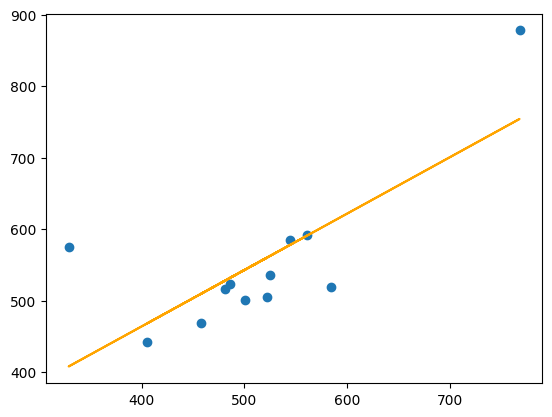

In [15]:
x = PSEs_block[:,0]
y = PSEs_block[:,1]
m, b = np.polyfit(x, y, 1)
plt.scatter(PSEs_block[:,0],PSEs_block[:,1])
plt.plot(x, m*x+b,color="orange")
stats.pearsonr(x,y)

In [ ]:
import psignifit as ps
PSEs = np.zeros((nSubj,2))
WFs = np.zeros((nSubj,2))
for iSub in range(nSubj):
    options                = dict()
    options['sigmoidName'] = 'logistic'   # choose a cumulative Gauss as the sigmoid
    options['expType']     = 'equalAsymptote'  
    data = all_time_resp[iSub,0,:,:]
    res = ps.psignifit(data, options)
    PSEs[iSub,0] = res['Fit'][0]
    jnd = (ps.getThreshold(res,0.75)[0]-ps.getThreshold(res,0.25)[0])/2
    WFs[iSub,0] = jnd / PSEs[iSub,0]
    print('PSE No Cue: ',res['Fit'][0])
    print('WF No Cue: ',WFs[iSub,0])
    ps.psigniplot.plotPsych(res,yLabel='Proportion Long',xLabel='Duration')
    plt.show()
    data = all_time_resp[iSub,1,:,:]
    res = ps.psignifit(data, options)
    print('PSE Hap Cue: ',res['Fit'][0])
    PSEs[iSub,1] = res['Fit'][0]
    jnd = (ps.getThreshold(res,0.75)[0]-ps.getThreshold(res,0.25)[0])/2
    WFs[iSub,1] = jnd / PSEs[iSub,1] 
    print('WF Hap Cue: ',WFs[iSub,1])
    ps.psigniplot.plotPsych(res,yLabel='Proportion Long',xLabel='Duration')
    plt.show()

In [18]:
col_pal = ['#C3C8CD','#414B56']

In [19]:

PSEs_old = PSEs
WFs_old = WFs
outlier =8
PSEs=np.delete(PSEs,outlier,axis=0)

WFs=np.delete(WFs,outlier,axis=0)
means=np.mean(PSEs,axis=0)
sems = np.std(PSEs,axis=0)

[514.50789696 503.35812883]
[50.30197719 42.30792017]
[0.24423154 0.17866953]
[0.03002606 0.03170511]


Text(-0.4, 0.265, 'B')

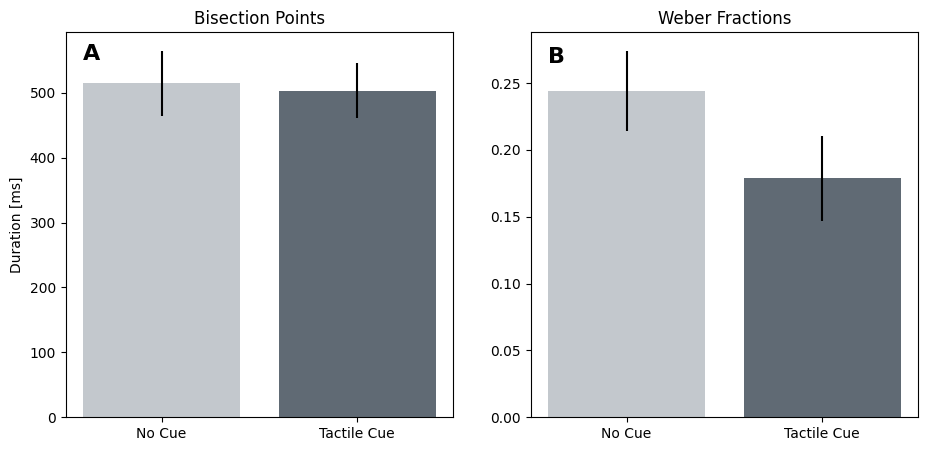

<Figure size 640x480 with 0 Axes>

In [22]:
from scipy.stats import sem
col_pal = ['#C3C8CD','#606A74','#414B56','#212930']
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(11,5))

means=np.mean(PSEs,axis=0)
sems = np.std(PSEs,axis=0)
print(means)
print(sems)
ax1.bar(['No Cue','Tactile Cue'],means,color = col_pal)
ax1.errorbar(['No Cue','Tactile Cue'],means,yerr=sems,fmt='None',color='black')
#plt.ylim([400,600])
ax1.set_title('Bisection Points')
ax1.set_ylabel('Duration [ms]')
ax1.text(-0.4,550,'A',fontsize=16,weight="bold")

means=np.mean(WFs,axis=0)
sems = sem(WFs,axis=0)
plt.figure()
print(means)
print(sems)
ax2.bar(['No Cue','Tactile Cue'],means,color = col_pal)
ax2.errorbar(['No Cue','Tactile Cue'],means,yerr=sems,fmt='None',color='black')
ax2.set_title('Weber Fractions')
ax2.text(-0.4,0.265,'B',fontsize=16,weight="bold")


In [18]:
import pingouin as pg
pg.ttest(WFs[:,0],WFs[:,1],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.91594,10,two-sided,0.000609,"[0.04, 0.1]",0.640208,61.55,0.483552


In [19]:
pg.ttest(all_mean_RTs[:,0],all_mean_RTs[:,1],paired=True)



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.090179,10,two-sided,0.000471,"[0.13, 0.32]",1.500327,76.502,0.993747


In [20]:
pg.ttest(PSEs[:,0],PSEs[:,1],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.756283,10,two-sided,0.466922,"[-21.7, 44.0]",0.228734,0.379,0.105769
